In [3]:
from keras import losses, metrics
from keras.models import Sequential
from keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization, Dropout, Activation
from keras.layers import GlobalAveragePooling1D, Flatten, SeparableConv1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import tensorflow as tf
import os, sys, pickle
import pandas as pd
import random, datetime, time

# GPU setting

In [9]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "3"

print(datetime.datetime.now())

2022-09-09 17:33:31.798892


# 1. Loading input

In [4]:
import pandas as pd
import numpy as np

BATCH_SIZE = 1024
MAX_CASES = 2000
SRATE = 100
LEN_INPUT = 60
OVERLAP = 0
LEN_PER_PRE = 60
LEN_PER_POST = 60
MODE = 'HR_mean'

print('loading train...', flush=True, end='')

# x를 loading해서 (batch_size, step, channel)
input_path = f"../DL_model/dataset/ne{LEN_PER_PRE}s-e{LEN_PER_POST}s-len{LEN_INPUT}-{OVERLAP}/"
x_train = np.load(input_path+'x_train.npz', allow_pickle=True)['arr_0']
x_test = np.load(input_path+'x_test.npz', allow_pickle=True)['arr_0']
x_val = np.load(input_path+'x_val.npz', allow_pickle=True)['arr_0']

rftn_train = np.load(input_path+'rftn_train.npz')['arr_0']
rftn_test = np.load(input_path+'rftn_test.npz')['arr_0']
rftn_val = np.load(input_path+'rftn_val.npz')['arr_0']

hr_train = np.load(input_path+'hr_train.npz')['arr_0']
hr_test = np.load(input_path+'hr_test.npz')['arr_0']
hr_val = np.load(input_path+'hr_val.npz')['arr_0']

hr_train_bin = hr_train > 0.25
hr_test_bin = hr_test > 0.25
hr_val_bin = hr_val > 0.25

gender_train = np.load(input_path+'gender_train.npz', allow_pickle=True)['arr_0']
gender_test = np.load(input_path+'gender_test.npz', allow_pickle=True)['arr_0']
gender_val = np.load(input_path+'gender_val.npz', allow_pickle=True)['arr_0']

age_train = np.load(input_path+'age_train.npz', allow_pickle=True)['arr_0']
age_test = np.load(input_path+'age_test.npz', allow_pickle=True)['arr_0']
age_val = np.load(input_path+'age_val.npz', allow_pickle=True)['arr_0']

rftn_train = np.reshape(rftn_train, [-1,6000,1])
input_train = np.concatenate((x_train, rftn_train), axis=2)
rftn_test = np.reshape(rftn_test, [-1,6000,1])
input_test = np.concatenate((x_test, rftn_test), axis=2)
rftn_val = np.reshape(rftn_val, [-1,6000,1])
input_val = np.concatenate((x_val, rftn_val), axis=2)

print('done', flush=True)

print('input_train shape:', input_train.shape)
print('input_test.shape:', input_test.shape)
print(f'input_val.shape: {input_val.shape}\n')

print(f'hr_train : mean {hr_train.mean():.2f}, max {hr_train.max():.2f}, min {hr_train.min():.2f}')
print(f'hr_val : mean {hr_val.mean():.2f}, max {hr_val.max():.2f}, min {hr_val.min():.2f}')
print(f'hr_test : mean {hr_test.mean():.2f}, max {hr_test.max():.2f}, min {hr_test.min():.2f}')

print(datetime.datetime.now())

loading train...done
input_train shape: (796, 6000, 3)
input_test.shape: (98, 6000, 3)
input_val.shape: (87, 6000, 3)

hr_train : mean 0.21, max 0.89, min -0.29
hr_val : mean 0.24, max 0.88, min -0.22
hr_test : mean 0.21, max 0.88, min -0.19
2022-10-31 12:23:03.859860


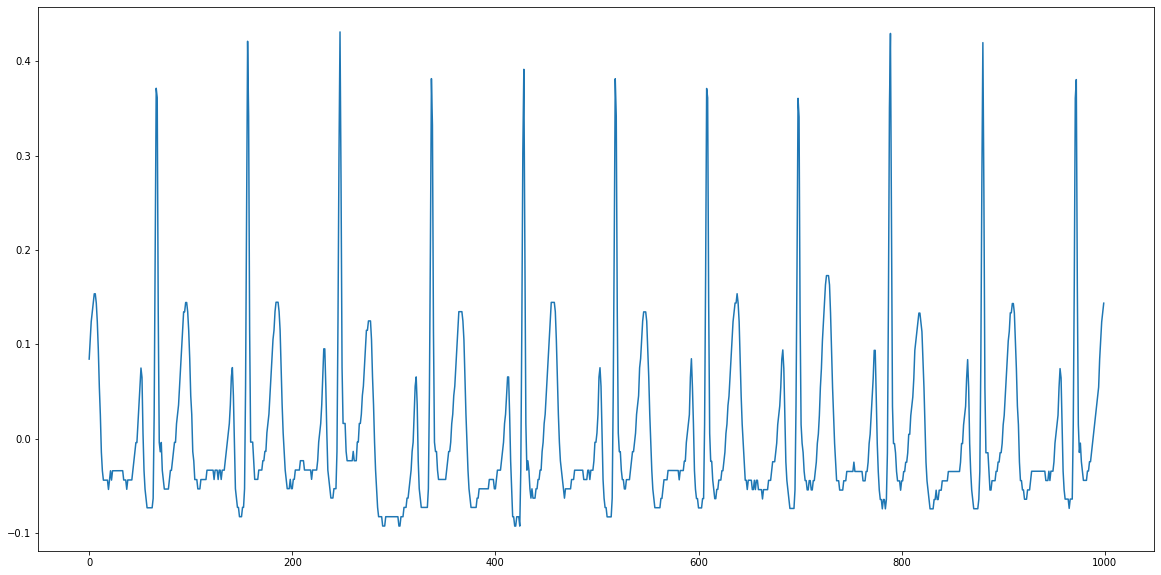

In [13]:
plt.figure(figsize=(20,10))
plt.plot(x_train[153,1000:2000,1])

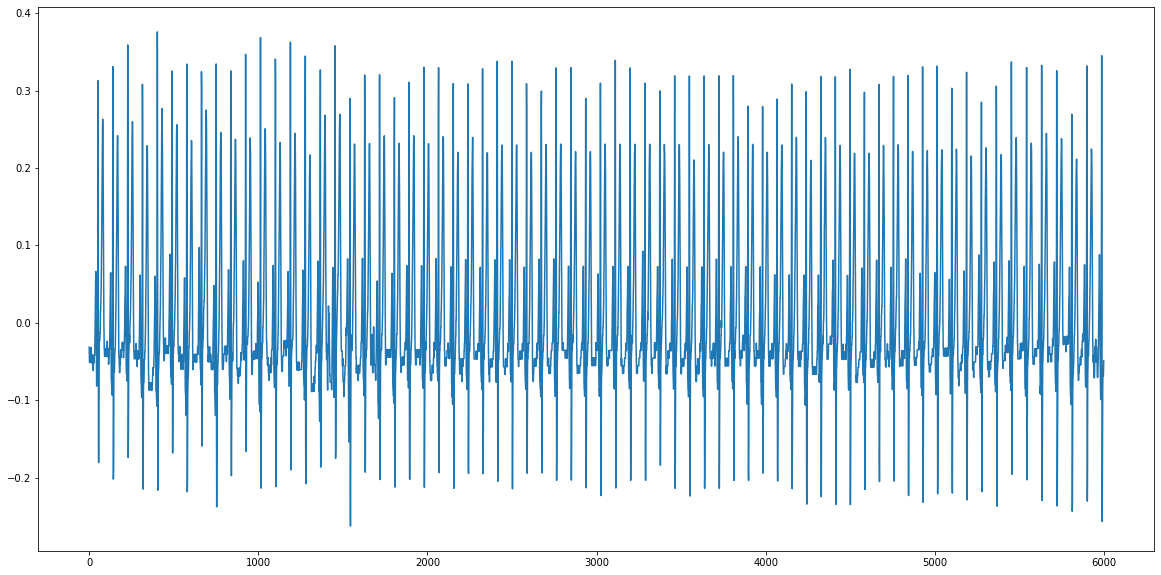

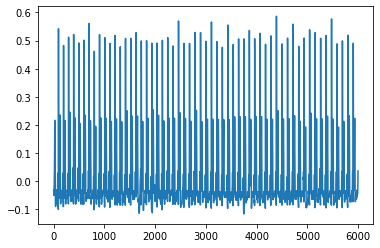

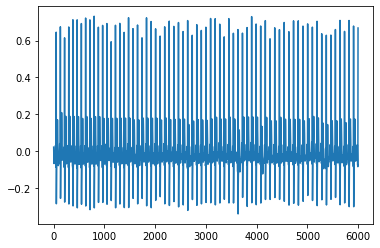

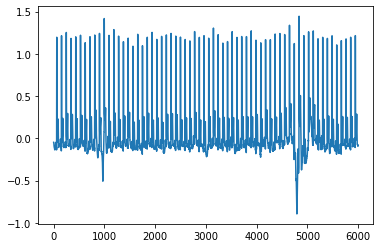

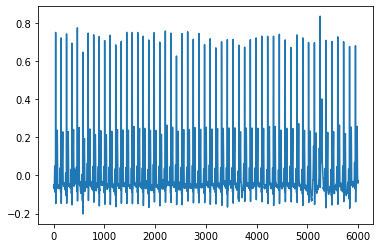

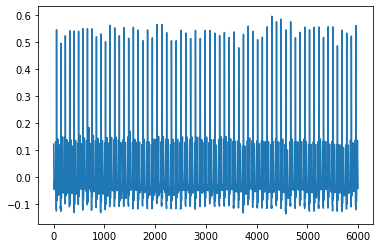

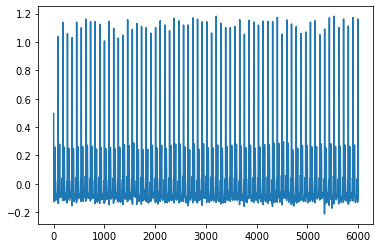

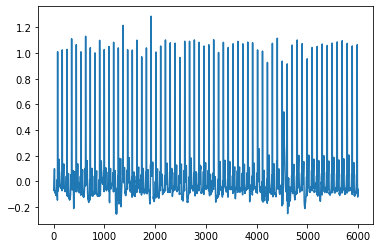

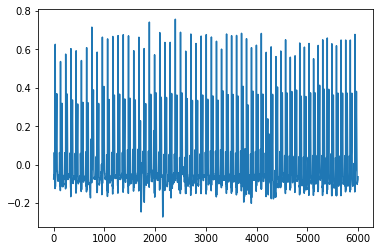

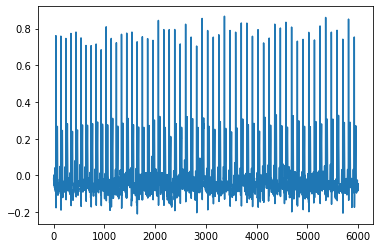

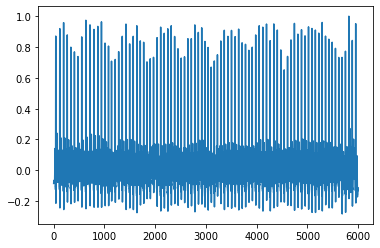

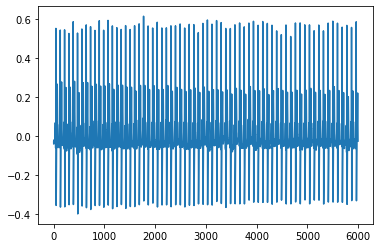

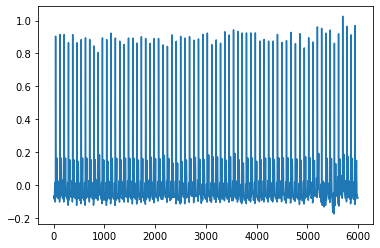

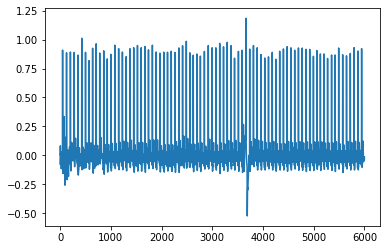

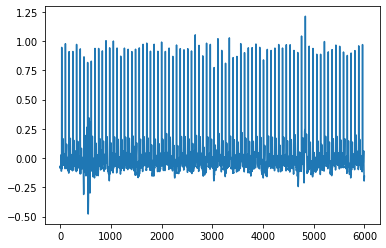

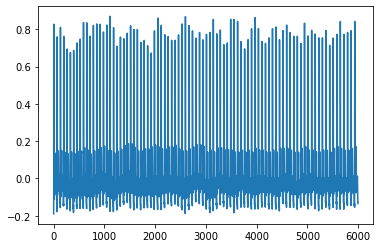

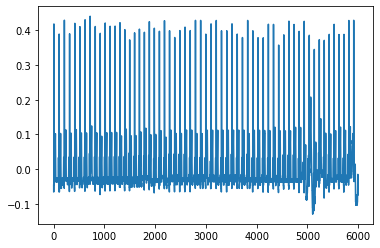

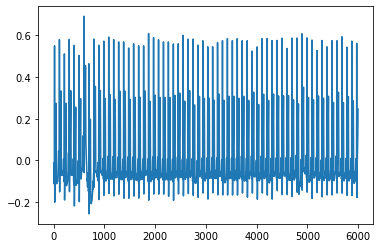

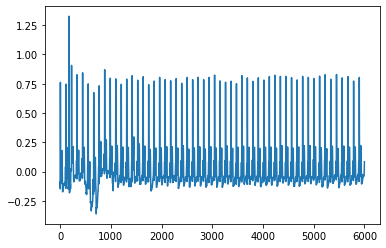

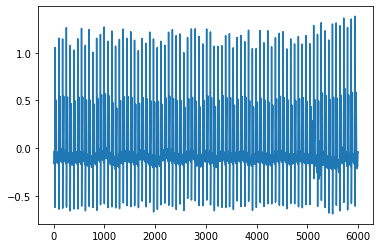

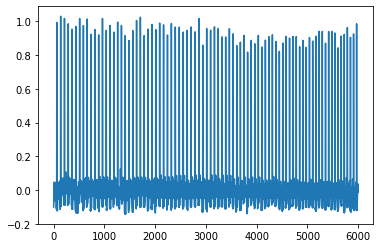

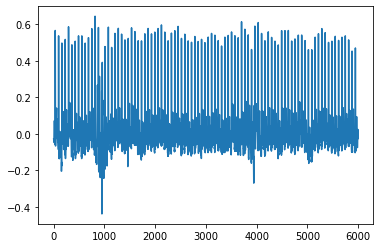

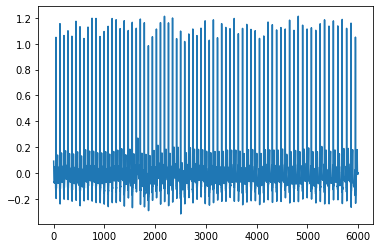

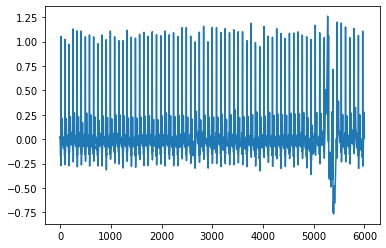

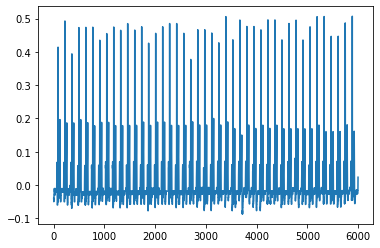

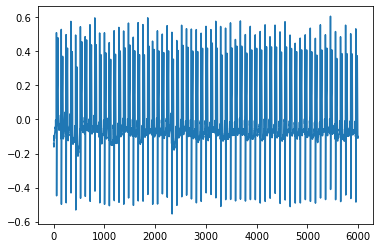

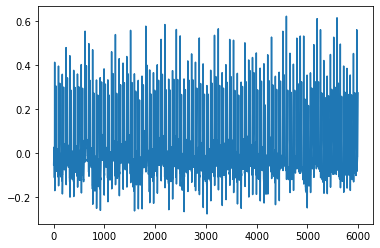

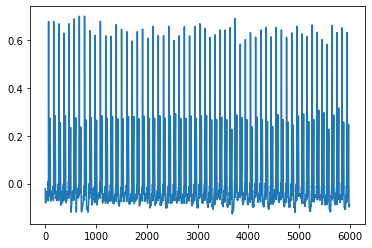

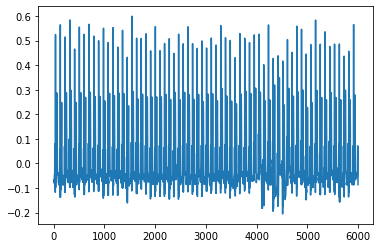

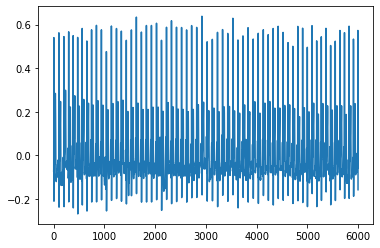

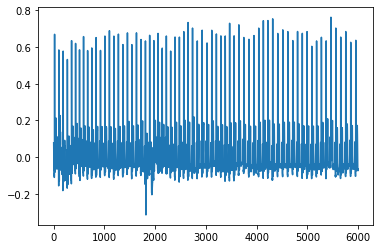

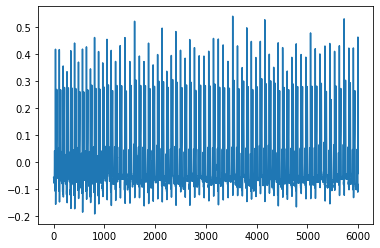

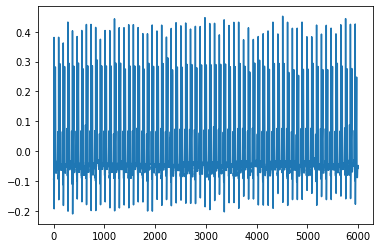

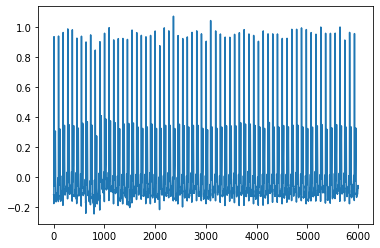

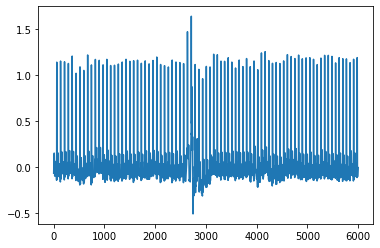

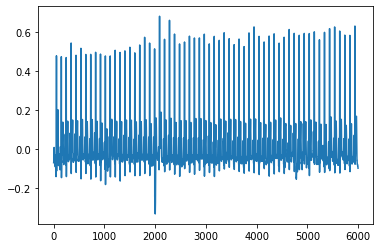

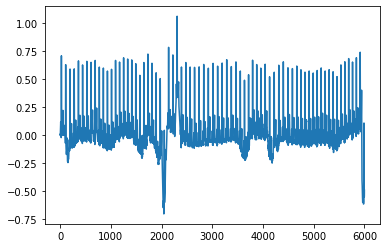

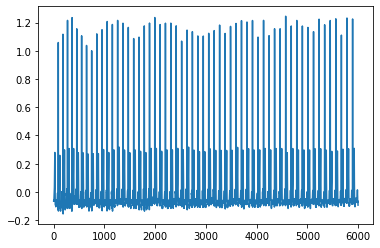

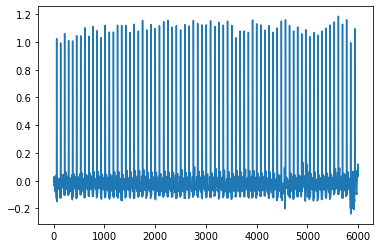

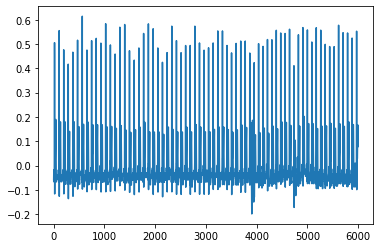

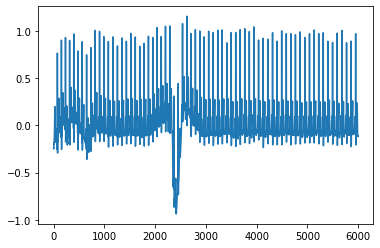

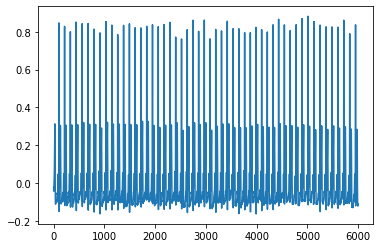

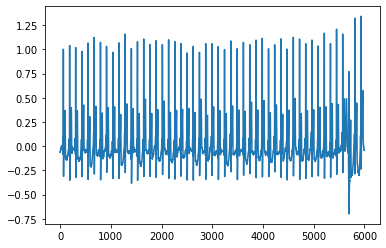

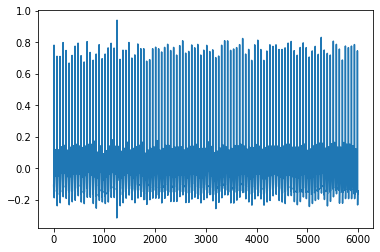

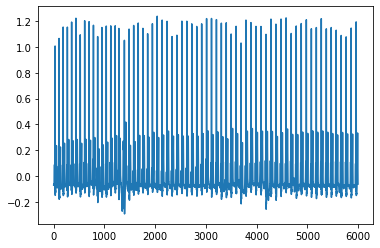

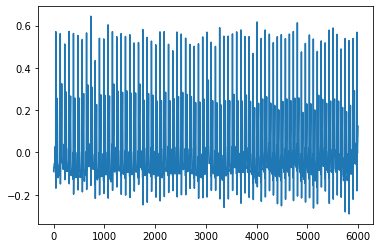

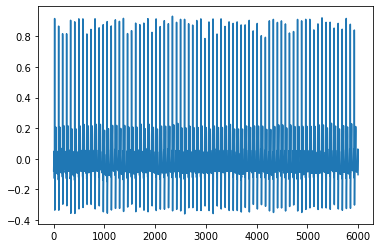

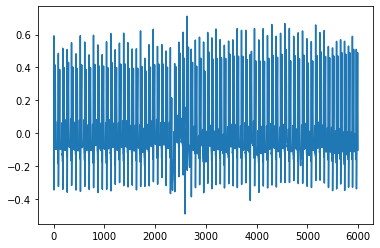

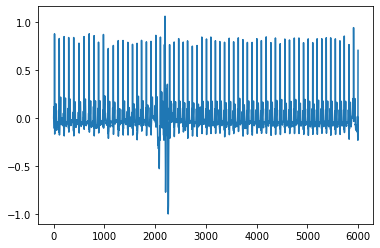

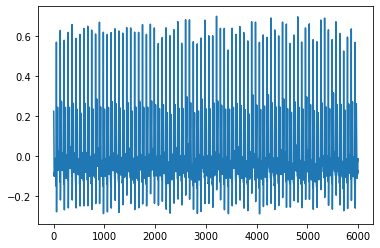

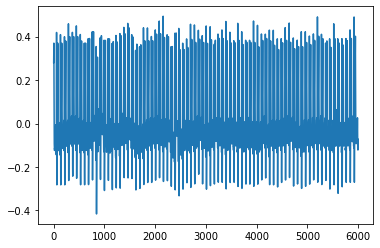

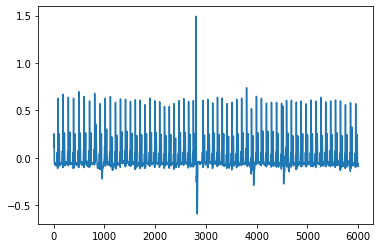

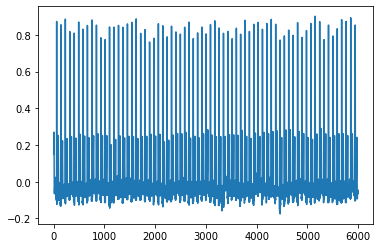

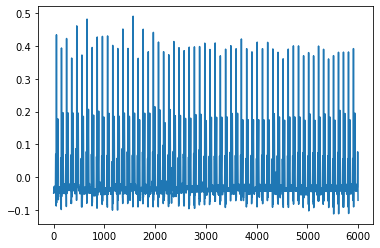

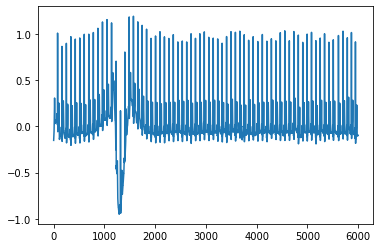

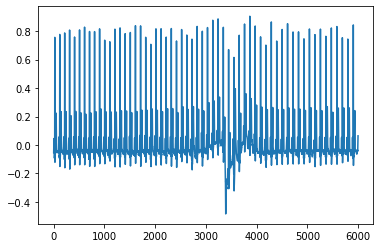

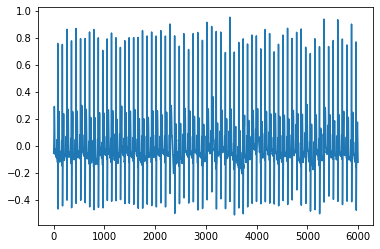

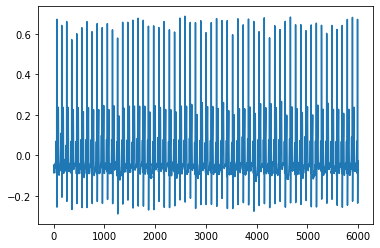

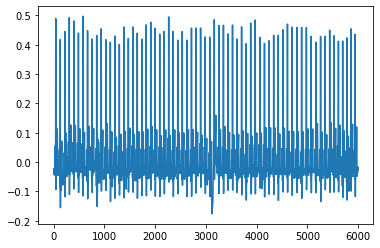

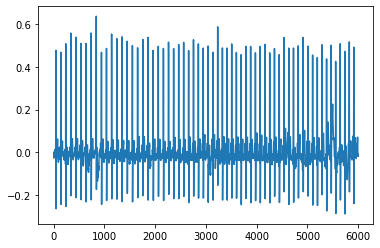

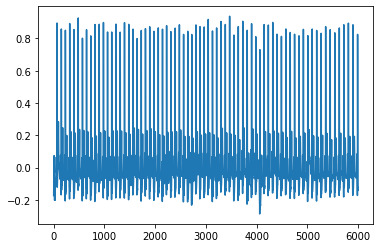

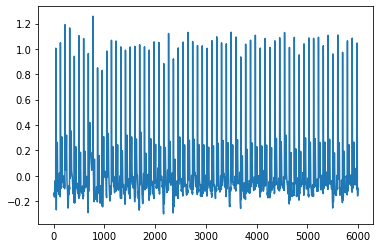

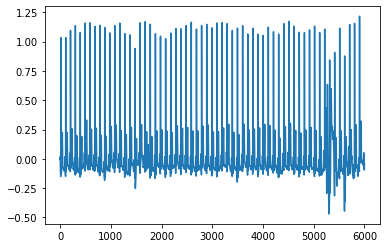

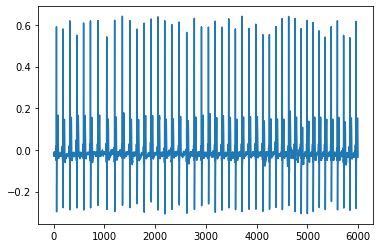

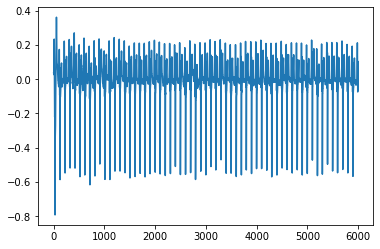

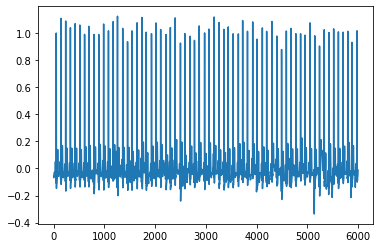

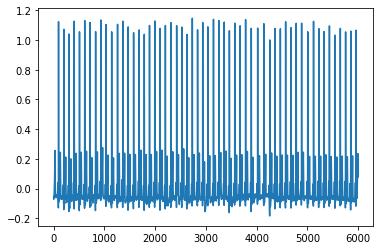

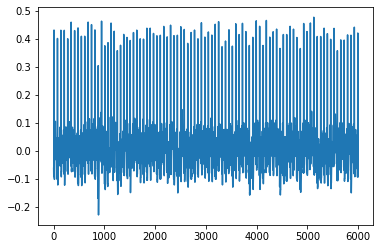

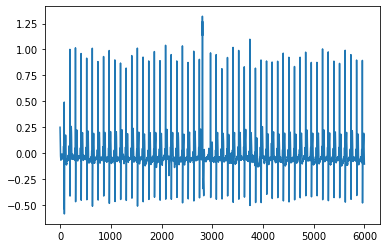

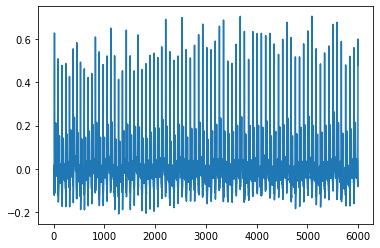

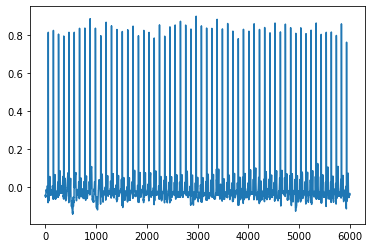

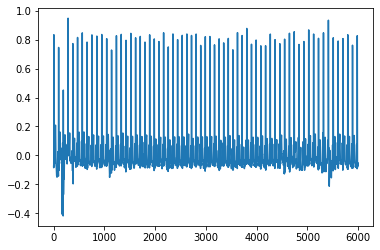

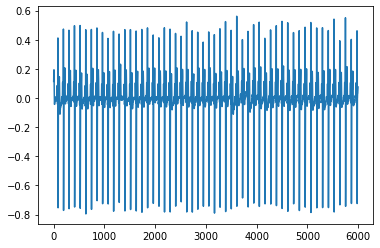

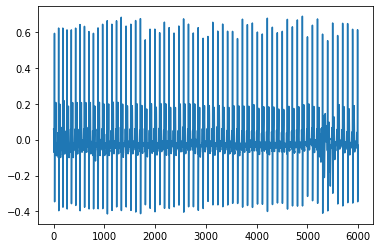

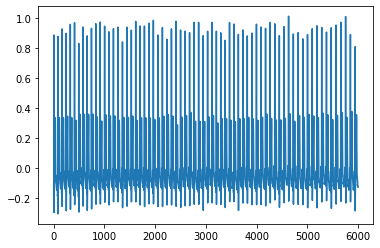

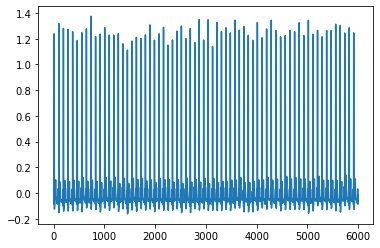

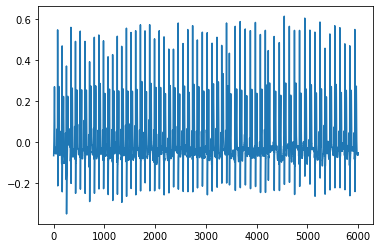

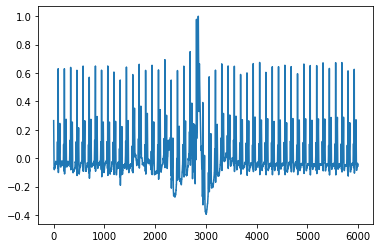

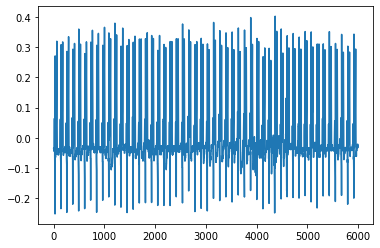

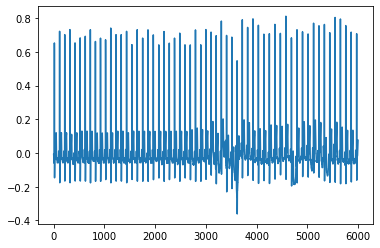

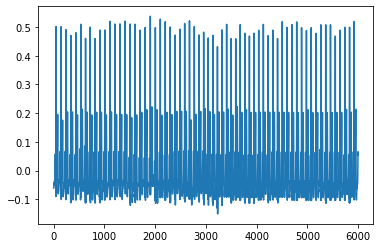

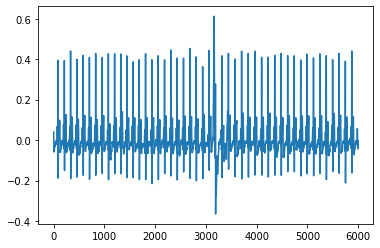

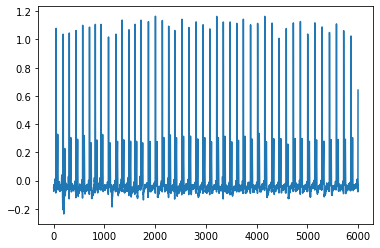

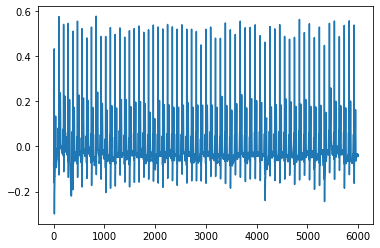

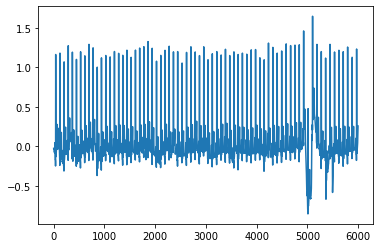

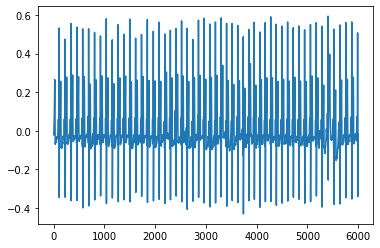

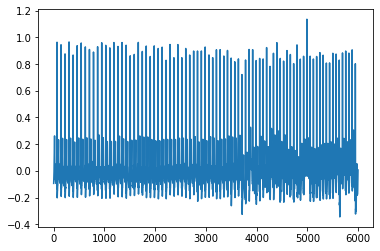

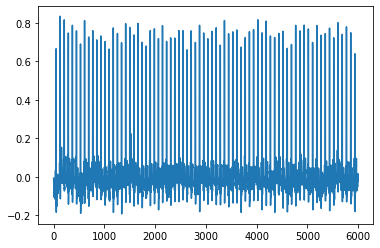

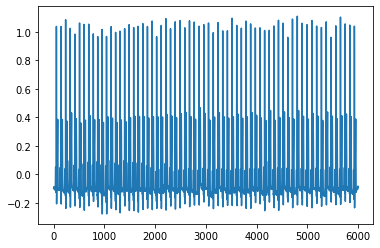

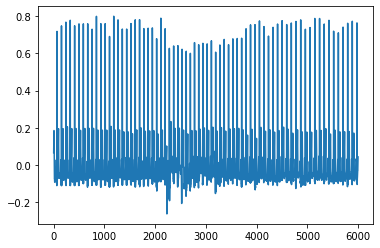

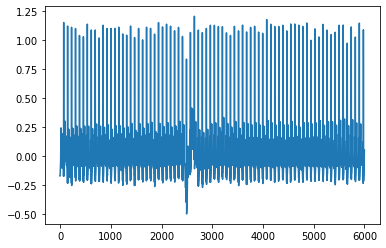

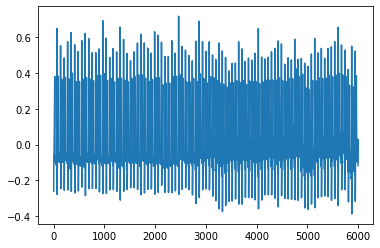

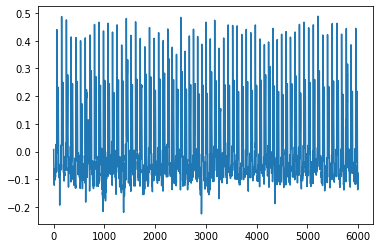

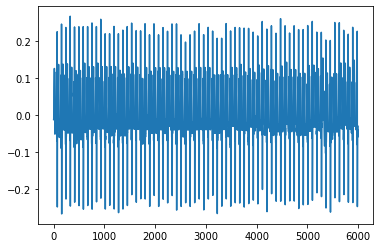

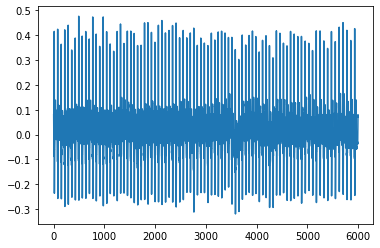

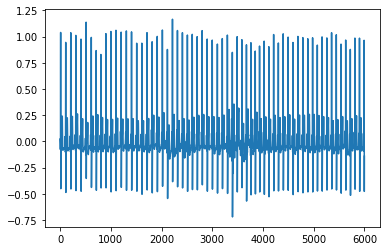

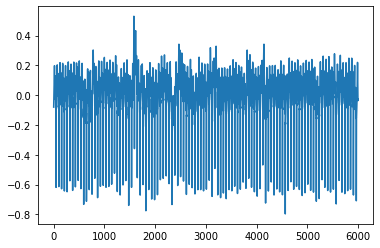

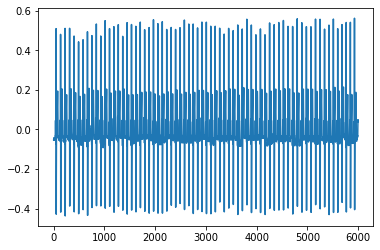

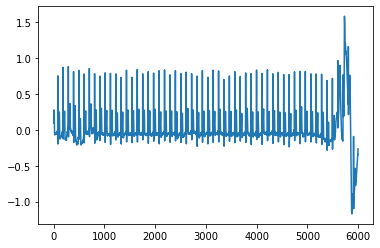

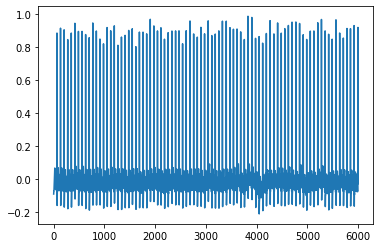

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))

num = 0
for i in range(num,num+100):
    plt.plot(x_train[i,:,1])
    plt.show()

## Input, output settings

## Sample weights

In [3]:
train_w_samp = np.ones(shape=(len(hr_train),))
val_w_samp = np.ones(shape=(len(hr_val),))
test_w_samp = np.ones(shape=(len(hr_test),))
print(datetime.datetime.now())

2022-09-09 17:26:42.719998


# 2. Setting

In [8]:
# folder
nfold = 1  # 각각의 hyperparameter에 대해 k-fold 를 시행하고 평균을 구한다.
ntest = 500
rootdir = f"randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_{nfold}fold_test{ntest}_w_samp0(train)_lr"

if not os.path.exists(rootdir):
    os.mkdir(rootdir)

# 모델에 대한 정보 txt로 저장
f = open(f'{rootdir}/README.txt', 'w')
f.write(f'model: 1D CNN 4 layers, binary classification')
f.write(f'input: ECG,PPG,RFTN of pre-intubation 120~60s, output: del HR 0.25 (post-intubation 0-60s)')
f.close()
    

# test_settings
test_settings_1, test_settings_2, test_settings_3 = [], [], []


# hyperparamters
#num_nodes = [64, 64, 64] #, 64, 64, 64]
#kernel_size = 10
pool_size = 2

#dense_node = 32
#dropout_rate = 0.2
learning_rate = 0.001

# hyperparamters pool
num_opts = [32, 64, 128, 256] # num of filters(kernel)
stride_opts = [1,1,1,1,1,2,2,2,2]
kernel_opts = range(3,9,2) # kernel size
dropout_opts  = [0, 0.1, 0.2, 0.3, 0.4, 0.5] # dropout rate
dense_opts = [0, 8, 16, 32, 64, 128]
globalpool_opts = ['max','ave']
BATCH_SIZE = [512, 1024]


print('start making test settings...', end='', flush=True)
# test settings
for num_l1 in num_opts:
    for num_l2 in num_opts:
        for num_l3 in num_opts:
            for num_l4 in num_opts:
                for kernel_l1 in kernel_opts:
                    for kernel_l2 in kernel_opts:
                        for kernel_l3 in kernel_opts:
                            for kernel_l4 in kernel_opts:
                                test_settings_1.append([num_l1, num_l2, num_l3, num_l4, kernel_l1, kernel_l2, kernel_l3, kernel_l4])

for dense_node in dense_opts:
    for dropout_cnn in dropout_opts:
        for dropout_fc in dropout_opts:
            for globalpool_opt in globalpool_opts:
                for batch_size in BATCH_SIZE:
                    for conv_double in [True, False]:
                        for learning_rate in [0.001, 0.002, 0.0005]:
                            test_settings_2.append([dense_node, dropout_cnn, dropout_fc, globalpool_opt, batch_size, conv_double, learning_rate])                                   

for stride_l1 in stride_opts:
    for stride_l2 in stride_opts:
        for stride_l3 in stride_opts:
            for stride_l4 in stride_opts:
                for stride_l5 in stride_opts:
                    for num_l5 in num_opts:
                        for kernel_l5 in kernel_opts:
                            test_settings_3.append([stride_l1, stride_l2, stride_l3, stride_l4, stride_l5, num_l5, kernel_l5])
                        
print('done')
print(datetime.datetime.now())

start making test settings...done
2022-09-09 17:30:06.714510


# 3. Random Search

## Regression model

In [ ]:
from keras import metrics


# random search for hyperparameter
ntrial = ntest
train_errs, val_errs = [] ,[]
test_acc, test_roc, test_prc = [], [], []
#test_rmse, test_mae, test_auc = [], [], []
random_settings = []


for itrial in range(ntrial):
    # grid search
    # test_setting = test_settings[itrial]

    # random search
    print('random search {}/{}'.format(itrial, ntrial))
    test_setting_1 = random.choice(test_settings_1)
    test_setting_2 = random.choice(test_settings_2)
    test_setting_3 = random.choice(test_settings_3)
        
        
    # test_setting
    num_l1, num_l2, num_l3, num_l4, kernel_l1, kernel_l2, kernel_l3, kernel_l4 = test_setting_1
    dense_node, dropout_cnn, dropout_fc, globalpool_opt, batch_size, conv_double, learning_rate = test_setting_2
    stride_l1, stride_l2, stride_l3, stride_l4, stride_l5, num_l5, kernel_l5 = test_setting_3
    
    
    # total conv layers of the model
    n_conv = random.choice([2,3,4])
    
    if n_conv==2:
        num_l3,kernel_l3,stride_l3 = 0,0,0
        num_l4,kernel_l4,stride_l4 = 0,0,0
        num_l5,kernel_l5,stride_l5 = 0,0,0
    
    if n_conv==3:
        num_l4,kernel_l4,stride_l4 = 0,0,0
        num_l5,kernel_l5,stride_l5 = 0,0,0
        
    if n_conv==4:
        num_l5,kernel_l5,stride_l5 = 0,0,0    
    

    # 이번 옵션에 대한 결과 디렉토리
    odir_f = f'batch={batch_size},c1={num_l1},c2={num_l2},c3={num_l3},c4={num_l4},filt1={kernel_l1},filt2={kernel_l2},filt3={kernel_l3},filt4={kernel_l4},str1={stride_l1}, \
        str2={stride_l2},str3={stride_l3},str4={stride_l4}, conv_double={conv_double},globalpool={globalpool_opt},dropout={dropout_cnn},dnodes={dense_node},dropout={dropout_fc},lr={learning_rate}'
    random_settings.append(odir_f)
    
    odir = rootdir + '/' + odir_f
    if not os.path.exists(odir):
        os.mkdir(odir)

    weightcache = "{}/weights.hdf5".format(odir)        

    
    with tf.device('/gpu:0'):
        # build a model
        model = Sequential()

        act='relu'

        # c1 layer
        if conv_double:
            model.add(Conv1D(filters=num_l1, kernel_size=kernel_l1, strides=stride_l1, padding='same'))
        model.add(Conv1D(filters=num_l1, kernel_size=kernel_l1, strides=stride_l1, padding='same', activation=act))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=pool_size))


        # c2 layer
        if num_l1 == 512:
            model.add(Conv1D(filters=128,kernel_size=1,padding='same'))
        if conv_double:
            model.add(Conv1D(filters=num_l2, kernel_size=kernel_l2, strides=stride_l2, padding='same'))
        model.add(Conv1D(filters=num_l2, kernel_size=kernel_l2, strides=stride_l2, padding='same', activation=act))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=pool_size))
        
        
        # c3 layer
        if n_conv>2:
            if num_l2 == 512:
                model.add(Conv1D(filters=128,kernel_size=1,padding='same'))
            if conv_double:
                model.add(Conv1D(filters=num_l3, kernel_size=kernel_l3, strides=stride_l3, padding='same'))
            model.add(Conv1D(filters=num_l3, kernel_size=kernel_l3, strides=stride_l3, padding='same', activation=act))
            model.add(BatchNormalization())
            model.add(MaxPooling1D(pool_size=pool_size))
        
        
        # c4 layer
        if n_conv>3:
            if num_l3 == 512:
                model.add(Conv1D(filters=128,kernel_size=1,padding='same'))
            if conv_double:
                model.add(Conv1D(filters=num_l4, kernel_size=kernel_l4, strides=stride_l4, padding='same'))
            model.add(Conv1D(filters=num_l4, kernel_size=kernel_l4, strides=stride_l4, padding='same', activation=act))
            model.add(BatchNormalization())
            model.add(MaxPooling1D(pool_size=pool_size))
            
        # c5 layer
        if n_conv>4:
            if num_l4 == 512:
                model.add(Conv1D(filters=128,kernel_size=1,padding='same'))
            if conv_double:
                model.add(Conv1D(filters=num_l5, kernel_size=kernel_l5, strides=stride_l5, padding='same'))
            model.add(Conv1D(filters=num_l5, kernel_size=kernel_l5, strides=stride_l5,padding='same', activation=act))
            model.add(BatchNormalization())
            model.add(MaxPooling1D(pool_size=pool_size))            
            


        # global이냐 flatten이냐는 따로 모델 나눠야 할듯
        if globalpool_opt == 'max':
            model.add(GlobalMaxPool1D())
        elif globalpool_opt == 'ave':
            model.add(GlobalAveragePooling1D())
            
            
        if dense_node != 0:
            model.add(Dropout(dropout_cnn))
            model.add(Dense(dense_node, activation='tanh'))
        model.add(Dropout(dropout_fc))
        model.add(Dense(1, activation='sigmoid'))


        # model 학습 설정
        try:
            model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=["acc", tf.keras.metrics.AUC()])
            hist = model.fit(input_train, hr_train_bin, sample_weight=train_w_samp, validation_data=(input_val, hr_val_bin, val_w_samp), epochs=100, batch_size=batch_size, #class_weight={0:1, 1:3}, 
                                    callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weightcache, verbose=1, save_best_only=True),
                                                EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')])
        except:
            os.rmdir(odir)
            #os.rename(odir,rootdir+'/error_{}'.format(odir_f))
            itrial -= 1
            test_roc.append(0)
            test_acc.append(0)
            test_prc.append(0)
            train_errs.append(-1)
            val_errs.append(-1)
            continue
            
            
    # 모델의 아키텍처 및 구조 저장
    open(odir+"/model.json", "wt").write(model.to_json())

    # test set에 대한 y_pred 계산
    model.load_weights(weightcache)  # fit 함수는 마지막 epoch의 결과를 리턴하기 때문에 best 결과를 다시 읽어들어야함
    y_pred = model.predict(input_test).flatten()

    
    # acc 계산
    acc = metrics.Accuracy()
    acc.update_state(y_pred>=0.5, hr_test_bin, sample_weight=test_w_samp)
    acc_val = acc.result().numpy()
    test_acc.append(acc_val)
    
    # auroc 계산
    false_positive_rate, true_positive_rate, threshold = roc_curve(hr_test_bin, y_pred, sample_weight=test_w_samp)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_roc.append(roc_auc)

    # auprc 
    precision, recall, _ = precision_recall_curve(hr_test_bin, y_pred, sample_weight=test_w_samp)
    prc_auc = auc(recall, precision)
    test_prc.append(prc_auc)

    
    # rename
    os.rename(odir, rootdir+'/roc{:.4f}_prc{:.4f}_{}_acc{:.2f}'.format(roc_auc, prc_auc, odir_f, acc_val))

    # train 과정에서의 err
    train_err = min(hist.history['loss'])
    val_err = min(hist.history['val_loss'])

    val_errs.append(val_err)
    train_errs.append(train_err)


    tf.keras.backend.clear_session()


max_idx = test_roc.index(max(test_auc))
print('\nBest Model roc:{:.4f}, info: {}'.format(test_roc(max_idx), random_settings(max_idx)))


random search 0/500
Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 5.7003 - acc: 0.3982 - auc_1: 0.4940
Epoch 00001: val_loss improved from inf to 9.96958, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=512,c1=256,c2=64,c3=0,c4=0,filt1=7,filt2=7,filt3=0,filt4=0,str1=1,         str2=1,str3=0,str4=0, conv_double=True,globalpool=max,dropout=0.3,dnodes=0,dropout=0,lr=0.002/weights.hdf5
2/2 [==============================] - 12s 4s/step - loss: 5.7003 - acc: 0.3982 - auc_1: 0.4940 - val_loss: 9.9696 - val_acc: 0.4483 - val_auc_1: 0.4952
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 1.6936 - acc: 0.4535 - auc_1: 0.5528
Epoch 00002: val_loss improved from 9.96958 to 2.43151, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=512,c1=256,c2=64,c3=0,c4=0,filt1=7,filt2=7,filt3=0,filt4=0,str1=1,         str2=1,str3=0,str4=0, conv_double=True,globalpool=max,dropout=

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100


2022-09-09 17:35:43.995241: W tensorflow/core/kernels/gpu_utils.cc:49] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


1/1 [==============================] - ETA: 0s - loss: 1.3198 - acc: 0.5075 - auc: 0.5652
Epoch 00001: val_loss improved from inf to 0.73667, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=1024,c1=256,c2=128,c3=32,c4=64,filt1=5,filt2=7,filt3=5,filt4=5,str1=1,         str2=2,str3=1,str4=2, conv_double=True,globalpool=max,dropout=0.2,dnodes=0,dropout=0,lr=0.0005/weights.hdf5
1/1 [==============================] - 11s 11s/step - loss: 1.3198 - acc: 0.5075 - auc: 0.5652 - val_loss: 0.7367 - val_acc: 0.5632 - val_auc: 0.5326
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.9865 - acc: 0.5038 - auc: 0.5269
Epoch 00002: val_loss did not improve from 0.73667
1/1 [==============================] - 1s 1s/step - loss: 0.9865 - acc: 0.5038 - auc: 0.5269 - val_loss: 0.7847 - val_acc: 0.4713 - val_auc: 0.5190
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.7420 - acc: 0.5678 - auc: 0.6295
Epoch 00003: val_loss 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.7529 - acc: 0.5427 - auc: 0.5430
Epoch 00001: val_loss improved from inf to 0.74170, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=512,c1=128,c2=128,c3=256,c4=0,filt1=3,filt2=7,filt3=3,filt4=0,str1=2,         str2=2,str3=2,str4=0, conv_double=True,globalpool=max,dropout=0.3,dnodes=8,dropout=0,lr=0.002/weights.hdf5
2/2 [==============================] - 4s 1s/step - loss: 0.7529 - acc: 0.5427 - auc: 0.5430 - val_loss: 0.7417 - val_acc: 0.4368 - val_auc: 0.5564
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.6805 - acc: 0.5741 - auc: 0.5983
Epoch 00002: val_loss improved from 0.74170 to 0.74086, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=512,c1=128,c2=128,c3=256,c4=0,filt1=3,filt2=7,filt3=3,filt4=0,str1=2,         str2=2,str3=2,str4=0, conv_double=True,globalpool=max,dropout=0.3,dnodes=8,dropout=0,

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.8169 - acc: 0.5163 - auc: 0.5295
Epoch 00001: val_loss improved from inf to 0.78595, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=1024,c1=128,c2=32,c3=0,c4=0,filt1=5,filt2=7,filt3=0,filt4=0,str1=2,         str2=2,str3=0,str4=0, conv_double=False,globalpool=max,dropout=0.1,dnodes=32,dropout=0.3,lr=0.002/weights.hdf5
1/1 [==============================] - 2s 2s/step - loss: 0.8169 - acc: 0.5163 - auc: 0.5295 - val_loss: 0.7860 - val_acc: 0.4368 - val_auc: 0.5088
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.8047 - acc: 0.5779 - auc: 0.5120
Epoch 00002: val_loss did not improve from 0.78595
1/1 [==============================] - 0s 213ms/step - loss: 0.8047 - acc: 0.5779 - auc: 0.5120 - val_loss: 0.7890 - val_acc: 0.4483 - val_auc: 0.5037
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.7727 - acc: 0.5603 - auc: 0.5293
Epoch 000

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.7857 - acc: 0.5377 - auc: 0.5441
Epoch 00001: val_loss improved from inf to 0.69887, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=512,c1=32,c2=128,c3=128,c4=128,filt1=5,filt2=3,filt3=7,filt4=3,str1=1,         str2=1,str3=1,str4=2, conv_double=True,globalpool=ave,dropout=0.3,dnodes=32,dropout=0.5,lr=0.001/weights.hdf5
2/2 [==============================] - 6s 2s/step - loss: 0.7857 - acc: 0.5377 - auc: 0.5441 - val_loss: 0.6989 - val_acc: 0.5517 - val_auc: 0.6181
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.7713 - acc: 0.5980 - auc: 0.5772
Epoch 00002: val_loss did not improve from 0.69887
2/2 [==============================] - 1s 226ms/step - loss: 0.7713 - acc: 0.5980 - auc: 0.5772 - val_loss: 0.7696 - val_acc: 0.5517 - val_auc: 0.5825
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 0.7055 - acc: 0.5704 - auc: 0.6150
Epoch 0

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.9082 - acc: 0.4937 - auc: 0.4970
Epoch 00001: val_loss improved from inf to 0.73695, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=512,c1=128,c2=32,c3=0,c4=0,filt1=7,filt2=3,filt3=0,filt4=0,str1=2,         str2=2,str3=0,str4=0, conv_double=False,globalpool=max,dropout=0.5,dnodes=64,dropout=0.4,lr=0.002/weights.hdf5
2/2 [==============================] - 2s 718ms/step - loss: 0.9082 - acc: 0.4937 - auc: 0.4970 - val_loss: 0.7369 - val_acc: 0.5517 - val_auc: 0.4712
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.8147 - acc: 0.5528 - auc: 0.5256
Epoch 00002: val_loss did not improve from 0.73695
2/2 [==============================] - 0s 150ms/step - loss: 0.8147 - acc: 0.5528 - auc: 0.5256 - val_loss: 0.7845 - val_acc: 0.5517 - val_auc: 0.4802
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 0.8468 - acc: 0.5377 - auc: 0.4978
Epoch 0

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.6812 - acc: 0.5628 - auc: 0.6058
Epoch 00001: val_loss improved from inf to 0.68732, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=1024,c1=128,c2=32,c3=0,c4=0,filt1=3,filt2=7,filt3=0,filt4=0,str1=2,         str2=1,str3=0,str4=0, conv_double=False,globalpool=ave,dropout=0.1,dnodes=128,dropout=0.2,lr=0.001/weights.hdf5
1/1 [==============================] - 2s 2s/step - loss: 0.6812 - acc: 0.5628 - auc: 0.6058 - val_loss: 0.6873 - val_acc: 0.5517 - val_auc: 0.6199
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.6595 - acc: 0.5603 - auc: 0.6156
Epoch 00002: val_loss did not improve from 0.68732
1/1 [==============================] - 0s 186ms/step - loss: 0.6595 - acc: 0.5603 - auc: 0.6156 - val_loss: 0.6916 - val_acc: 0.5517 - val_auc: 0.6389
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.6498 - acc: 0.5867 - auc: 0.6173
Epoch 00

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.8106 - acc: 0.5276 - auc: 0.5039
Epoch 00001: val_loss improved from inf to 1.20506, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=1024,c1=128,c2=64,c3=256,c4=128,filt1=5,filt2=7,filt3=7,filt4=5,str1=2,         str2=2,str3=1,str4=1, conv_double=False,globalpool=ave,dropout=0.2,dnodes=16,dropout=0.5,lr=0.001/weights.hdf5
1/1 [==============================] - 3s 3s/step - loss: 0.8106 - acc: 0.5276 - auc: 0.5039 - val_loss: 1.2051 - val_acc: 0.5517 - val_auc: 0.6207
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 1.1022 - acc: 0.5804 - auc: 0.6078
Epoch 00002: val_loss did not improve from 1.20506
1/1 [==============================] - 0s 260ms/step - loss: 1.1022 - acc: 0.5804 - auc: 0.6078 - val_loss: 1.2302 - val_acc: 0.5517 - val_auc: 0.6509
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.8473 - acc: 0.5678 - auc: 0.6094
Epoch

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.8168 - acc: 0.4849 - auc: 0.5354
Epoch 00001: val_loss improved from inf to 1.09750, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=1024,c1=32,c2=256,c3=128,c4=0,filt1=5,filt2=7,filt3=3,filt4=0,str1=2,         str2=1,str3=2,str4=0, conv_double=True,globalpool=max,dropout=0.1,dnodes=16,dropout=0.1,lr=0.002/weights.hdf5
1/1 [==============================] - 4s 4s/step - loss: 0.8168 - acc: 0.4849 - auc: 0.5354 - val_loss: 1.0975 - val_acc: 0.4483 - val_auc: 0.4933
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.7136 - acc: 0.5791 - auc: 0.5897
Epoch 00002: val_loss improved from 1.09750 to 1.08232, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=1024,c1=32,c2=256,c3=128,c4=0,filt1=5,filt2=7,filt3=3,filt4=0,str1=2,         str2=1,str3=2,str4=0, conv_double=True,globalpool=max,dropout=0.1,dnodes=16,dropou

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.8283 - acc: 0.5000 - auc: 0.4808
Epoch 00001: val_loss improved from inf to 0.87621, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=1024,c1=256,c2=32,c3=0,c4=0,filt1=5,filt2=7,filt3=0,filt4=0,str1=1,         str2=1,str3=0,str4=0, conv_double=False,globalpool=max,dropout=0,dnodes=8,dropout=0.3,lr=0.002/weights.hdf5
1/1 [==============================] - 3s 3s/step - loss: 0.8283 - acc: 0.5000 - auc: 0.4808 - val_loss: 0.8762 - val_acc: 0.4483 - val_auc: 0.5302
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.7929 - acc: 0.4460 - auc: 0.4623
Epoch 00002: val_loss improved from 0.87621 to 0.69756, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=1024,c1=256,c2=32,c3=0,c4=0,filt1=5,filt2=7,filt3=0,filt4=0,str1=1,         str2=1,str3=0,str4=0, conv_double=False,globalpool=max,dropout=0,dnodes=8,dropout=0.3,lr

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.7617 - acc: 0.5214 - auc: 0.5035
Epoch 00001: val_loss improved from inf to 1.47079, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=512,c1=128,c2=32,c3=0,c4=0,filt1=5,filt2=3,filt3=0,filt4=0,str1=1,         str2=1,str3=0,str4=0, conv_double=True,globalpool=max,dropout=0,dnodes=16,dropout=0.1,lr=0.002/weights.hdf5
2/2 [==============================] - 4s 2s/step - loss: 0.7617 - acc: 0.5214 - auc: 0.5035 - val_loss: 1.4708 - val_acc: 0.4483 - val_auc: 0.4485
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.7314 - acc: 0.6005 - auc: 0.5212
Epoch 00002: val_loss improved from 1.47079 to 1.00782, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=512,c1=128,c2=32,c3=0,c4=0,filt1=5,filt2=3,filt3=0,filt4=0,str1=1,         str2=1,str3=0,str4=0, conv_double=True,globalpool=max,dropout=0,dnodes=16,dropout=0.1,lr=0

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.9536 - acc: 0.4422 - auc: 0.5107
Epoch 00001: val_loss improved from inf to 0.77687, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=512,c1=64,c2=32,c3=64,c4=32,filt1=5,filt2=7,filt3=7,filt4=3,str1=1,         str2=1,str3=2,str4=1, conv_double=True,globalpool=max,dropout=0,dnodes=128,dropout=0.3,lr=0.001/weights.hdf5
2/2 [==============================] - 5s 2s/step - loss: 0.9536 - acc: 0.4422 - auc: 0.5107 - val_loss: 0.7769 - val_acc: 0.4483 - val_auc: 0.5548
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.7252 - acc: 0.5603 - auc: 0.5266
Epoch 00002: val_loss improved from 0.77687 to 0.72921, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=512,c1=64,c2=32,c3=64,c4=32,filt1=5,filt2=7,filt3=7,filt4=3,str1=1,         str2=1,str3=2,str4=1, conv_double=True,globalpool=max,dropout=0,dnodes=128,dropout=0.3,

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.7850 - acc: 0.4523 - auc: 0.4347
Epoch 00001: val_loss improved from inf to 1.11999, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=1024,c1=128,c2=256,c3=32,c4=0,filt1=5,filt2=7,filt3=7,filt4=0,str1=1,         str2=1,str3=2,str4=0, conv_double=True,globalpool=ave,dropout=0.5,dnodes=128,dropout=0.3,lr=0.002/weights.hdf5
1/1 [==============================] - 10s 10s/step - loss: 0.7850 - acc: 0.4523 - auc: 0.4347 - val_loss: 1.1200 - val_acc: 0.5517 - val_auc: 0.6095
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.6983 - acc: 0.5389 - auc: 0.5615
Epoch 00002: val_loss improved from 1.11999 to 0.95101, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=1024,c1=128,c2=256,c3=32,c4=0,filt1=5,filt2=7,filt3=7,filt4=0,str1=1,         str2=1,str3=2,str4=0, conv_double=True,globalpool=ave,dropout=0.5,dnodes=128,dr

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 2.1459 - acc: 0.6106 - auc: 0.5404
Epoch 00001: val_loss improved from inf to 0.92001, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=512,c1=32,c2=64,c3=32,c4=128,filt1=3,filt2=7,filt3=7,filt4=7,str1=1,         str2=1,str3=1,str4=1, conv_double=False,globalpool=max,dropout=0.2,dnodes=0,dropout=0,lr=0.0005/weights.hdf5
2/2 [==============================] - 4s 1s/step - loss: 2.1459 - acc: 0.6106 - auc: 0.5404 - val_loss: 0.9200 - val_acc: 0.5517 - val_auc: 0.5438
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 1.0855 - acc: 0.5791 - auc: 0.5355
Epoch 00002: val_loss did not improve from 0.92001
2/2 [==============================] - 0s 117ms/step - loss: 1.0855 - acc: 0.5791 - auc: 0.5355 - val_loss: 0.9320 - val_acc: 0.5517 - val_auc: 0.5478
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 0.7542 - acc: 0.6168 - auc: 0.6230
Epoch 0000

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.7302 - acc: 0.5214 - auc: 0.5433
Epoch 00001: val_loss improved from inf to 0.89269, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=512,c1=128,c2=128,c3=128,c4=32,filt1=7,filt2=5,filt3=7,filt4=5,str1=1,         str2=1,str3=2,str4=2, conv_double=True,globalpool=ave,dropout=0.4,dnodes=128,dropout=0.3,lr=0.0005/weights.hdf5
2/2 [==============================] - 5s 1s/step - loss: 0.7302 - acc: 0.5214 - auc: 0.5433 - val_loss: 0.8927 - val_acc: 0.5517 - val_auc: 0.5764
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.6955 - acc: 0.5729 - auc: 0.6086
Epoch 00002: val_loss did not improve from 0.89269
2/2 [==============================] - 1s 366ms/step - loss: 0.6955 - acc: 0.5729 - auc: 0.6086 - val_loss: 0.9352 - val_acc: 0.5517 - val_auc: 0.5537
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 0.6692 - acc: 0.5766 - auc: 0.6154
Epoch

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 2.0301 - acc: 0.4987 - auc: 0.5023
Epoch 00001: val_loss improved from inf to 1.68774, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=512,c1=256,c2=32,c3=256,c4=0,filt1=3,filt2=3,filt3=7,filt4=0,str1=1,         str2=2,str3=2,str4=0, conv_double=True,globalpool=max,dropout=0,dnodes=0,dropout=0.4,lr=0.001/weights.hdf5
2/2 [==============================] - 8s 3s/step - loss: 2.0301 - acc: 0.4987 - auc: 0.5023 - val_loss: 1.6877 - val_acc: 0.4598 - val_auc: 0.5363
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 1.5634 - acc: 0.5553 - auc: 0.6076
Epoch 00002: val_loss did not improve from 1.68774
2/2 [==============================] - 1s 460ms/step - loss: 1.5634 - acc: 0.5553 - auc: 0.6076 - val_loss: 3.6313 - val_acc: 0.4483 - val_auc: 0.5096
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 1.2395 - acc: 0.6206 - auc: 0.6355
Epoch 00003:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.7649 - acc: 0.5214 - auc: 0.5074
Epoch 00001: val_loss improved from inf to 0.69633, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=512,c1=256,c2=32,c3=0,c4=0,filt1=5,filt2=3,filt3=0,filt4=0,str1=2,         str2=1,str3=0,str4=0, conv_double=True,globalpool=max,dropout=0.3,dnodes=64,dropout=0.2,lr=0.001/weights.hdf5
2/2 [==============================] - 5s 2s/step - loss: 0.7649 - acc: 0.5214 - auc: 0.5074 - val_loss: 0.6963 - val_acc: 0.5632 - val_auc: 0.4786
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.7518 - acc: 0.5440 - auc: 0.5325
Epoch 00002: val_loss did not improve from 0.69633
2/2 [==============================] - 1s 285ms/step - loss: 0.7518 - acc: 0.5440 - auc: 0.5325 - val_loss: 0.7297 - val_acc: 0.5632 - val_auc: 0.5075
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 0.7420 - acc: 0.5817 - auc: 0.5381
Epoch 00003

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.7519 - acc: 0.5176 - auc: 0.4795
Epoch 00001: val_loss improved from inf to 1.66040, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=1024,c1=128,c2=256,c3=64,c4=0,filt1=7,filt2=5,filt3=7,filt4=0,str1=2,         str2=1,str3=2,str4=0, conv_double=True,globalpool=ave,dropout=0.3,dnodes=64,dropout=0.3,lr=0.001/weights.hdf5
1/1 [==============================] - 5s 5s/step - loss: 0.7519 - acc: 0.5176 - auc: 0.4795 - val_loss: 1.6604 - val_acc: 0.5517 - val_auc: 0.5817
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.8300 - acc: 0.5616 - auc: 0.5923
Epoch 00002: val_loss improved from 1.66040 to 1.54334, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=1024,c1=128,c2=256,c3=64,c4=0,filt1=7,filt2=5,filt3=7,filt4=0,str1=2,         str2=1,str3=2,str4=0, conv_double=True,globalpool=ave,dropout=0.3,dnodes=64,dropou

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.8828 - acc: 0.5402 - auc: 0.5005
Epoch 00001: val_loss improved from inf to 0.71638, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=512,c1=128,c2=32,c3=256,c4=0,filt1=3,filt2=7,filt3=5,filt4=0,str1=2,         str2=2,str3=2,str4=0, conv_double=False,globalpool=max,dropout=0.2,dnodes=32,dropout=0.4,lr=0.001/weights.hdf5
2/2 [==============================] - 3s 882ms/step - loss: 0.8828 - acc: 0.5402 - auc: 0.5005 - val_loss: 0.7164 - val_acc: 0.5517 - val_auc: 0.5069
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.8193 - acc: 0.5590 - auc: 0.5465
Epoch 00002: val_loss did not improve from 0.71638
2/2 [==============================] - 0s 100ms/step - loss: 0.8193 - acc: 0.5590 - auc: 0.5465 - val_loss: 0.7636 - val_acc: 0.5517 - val_auc: 0.6207
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 0.8057 - acc: 0.5691 - auc: 0.5451
Epoch

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.7970 - acc: 0.4497 - auc: 0.4351
Epoch 00001: val_loss improved from inf to 0.68360, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=1024,c1=64,c2=256,c3=0,c4=0,filt1=7,filt2=3,filt3=0,filt4=0,str1=2,         str2=1,str3=0,str4=0, conv_double=False,globalpool=ave,dropout=0.4,dnodes=64,dropout=0.3,lr=0.001/weights.hdf5
1/1 [==============================] - 2s 2s/step - loss: 0.7970 - acc: 0.4497 - auc: 0.4351 - val_loss: 0.6836 - val_acc: 0.5632 - val_auc: 0.6076
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.7115 - acc: 0.5188 - auc: 0.5317
Epoch 00002: val_loss improved from 0.68360 to 0.68131, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=1024,c1=64,c2=256,c3=0,c4=0,filt1=7,filt2=3,filt3=0,filt4=0,str1=2,         str2=1,str3=0,str4=0, conv_double=False,globalpool=ave,dropout=0.4,dnodes=64,dropout=

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.8015 - acc: 0.5289 - auc: 0.5216
Epoch 00001: val_loss improved from inf to 0.71231, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=512,c1=32,c2=32,c3=128,c4=0,filt1=3,filt2=7,filt3=7,filt4=0,str1=1,         str2=1,str3=1,str4=0, conv_double=True,globalpool=ave,dropout=0.3,dnodes=8,dropout=0.1,lr=0.002/weights.hdf5
2/2 [==============================] - 3s 894ms/step - loss: 0.8015 - acc: 0.5289 - auc: 0.5216 - val_loss: 0.7123 - val_acc: 0.4483 - val_auc: 0.6157
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.6899 - acc: 0.5616 - auc: 0.5778
Epoch 00002: val_loss improved from 0.71231 to 0.69645, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=512,c1=32,c2=32,c3=128,c4=0,filt1=3,filt2=7,filt3=7,filt4=0,str1=1,         str2=1,str3=1,str4=0, conv_double=True,globalpool=ave,dropout=0.3,dnodes=8,dropout=0

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.7342 - acc: 0.5126 - auc: 0.5294
Epoch 00001: val_loss improved from inf to 0.75239, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=1024,c1=128,c2=128,c3=64,c4=0,filt1=7,filt2=5,filt3=3,filt4=0,str1=1,         str2=2,str3=1,str4=0, conv_double=False,globalpool=ave,dropout=0.5,dnodes=32,dropout=0,lr=0.0005/weights.hdf5
1/1 [==============================] - 3s 3s/step - loss: 0.7342 - acc: 0.5126 - auc: 0.5294 - val_loss: 0.7524 - val_acc: 0.4483 - val_auc: 0.3851
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.6708 - acc: 0.5704 - auc: 0.5954
Epoch 00002: val_loss improved from 0.75239 to 0.73163, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=1024,c1=128,c2=128,c3=64,c4=0,filt1=7,filt2=5,filt3=3,filt4=0,str1=1,         str2=2,str3=1,str4=0, conv_double=False,globalpool=ave,dropout=0.5,dnodes=32,dropo

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.8158 - acc: 0.5578 - auc: 0.4733
Epoch 00001: val_loss improved from inf to 0.73967, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=1024,c1=64,c2=128,c3=64,c4=64,filt1=3,filt2=5,filt3=3,filt4=5,str1=1,         str2=2,str3=1,str4=2, conv_double=False,globalpool=max,dropout=0,dnodes=16,dropout=0.3,lr=0.002/weights.hdf5
1/1 [==============================] - 3s 3s/step - loss: 0.8158 - acc: 0.5578 - auc: 0.4733 - val_loss: 0.7397 - val_acc: 0.5517 - val_auc: 0.5649
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.7954 - acc: 0.5302 - auc: 0.5521
Epoch 00002: val_loss did not improve from 0.73967
1/1 [==============================] - 0s 268ms/step - loss: 0.7954 - acc: 0.5302 - auc: 0.5521 - val_loss: 0.7516 - val_acc: 0.5517 - val_auc: 0.6322
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.7247 - acc: 0.6005 - auc: 0.5910
Epoch 000

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.8121 - acc: 0.5854 - auc: 0.5120
Epoch 00001: val_loss improved from inf to 2.23369, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=1024,c1=32,c2=32,c3=256,c4=0,filt1=3,filt2=3,filt3=3,filt4=0,str1=2,         str2=2,str3=1,str4=0, conv_double=True,globalpool=ave,dropout=0.4,dnodes=0,dropout=0.3,lr=0.002/weights.hdf5
1/1 [==============================] - 4s 4s/step - loss: 0.8121 - acc: 0.5854 - auc: 0.5120 - val_loss: 2.2337 - val_acc: 0.5517 - val_auc: 0.6124
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 1.4136 - acc: 0.5528 - auc: 0.6256
Epoch 00002: val_loss improved from 2.23369 to 1.49981, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=1024,c1=32,c2=32,c3=256,c4=0,filt1=3,filt2=3,filt3=3,filt4=0,str1=2,         str2=2,str3=1,str4=0, conv_double=True,globalpool=ave,dropout=0.4,dnodes=0,dropout=0.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.9621 - acc: 0.5063 - auc: 0.4917
Epoch 00001: val_loss improved from inf to 0.70182, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=1024,c1=32,c2=32,c3=256,c4=128,filt1=5,filt2=3,filt3=7,filt4=3,str1=1,         str2=1,str3=1,str4=1, conv_double=True,globalpool=max,dropout=0.4,dnodes=16,dropout=0.4,lr=0.0005/weights.hdf5
1/1 [==============================] - 7s 7s/step - loss: 0.9621 - acc: 0.5063 - auc: 0.4917 - val_loss: 0.7018 - val_acc: 0.4943 - val_auc: 0.5529
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.9631 - acc: 0.5364 - auc: 0.4931
Epoch 00002: val_loss improved from 0.70182 to 0.70099, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=1024,c1=32,c2=32,c3=256,c4=128,filt1=5,filt2=3,filt3=7,filt4=3,str1=1,         str2=1,str3=1,str4=1, conv_double=True,globalpool=max,dropout=0.4,dnodes=16,dro

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.8837 - acc: 0.4786 - auc: 0.4410
Epoch 00001: val_loss improved from inf to 0.75078, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=1024,c1=64,c2=128,c3=32,c4=0,filt1=5,filt2=3,filt3=3,filt4=0,str1=2,         str2=2,str3=1,str4=0, conv_double=True,globalpool=ave,dropout=0.3,dnodes=0,dropout=0.5,lr=0.002/weights.hdf5
1/1 [==============================] - 3s 3s/step - loss: 0.8837 - acc: 0.4786 - auc: 0.4410 - val_loss: 0.7508 - val_acc: 0.5172 - val_auc: 0.5457
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.9330 - acc: 0.5528 - auc: 0.5793
Epoch 00002: val_loss did not improve from 0.75078
1/1 [==============================] - 0s 151ms/step - loss: 0.9330 - acc: 0.5528 - auc: 0.5793 - val_loss: 0.8852 - val_acc: 0.5517 - val_auc: 0.5767
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.7624 - acc: 0.5126 - auc: 0.5508
Epoch 0000

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.8210 - acc: 0.4724 - auc: 0.4997
Epoch 00001: val_loss improved from inf to 0.68645, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=512,c1=128,c2=64,c3=64,c4=64,filt1=3,filt2=5,filt3=7,filt4=7,str1=1,         str2=1,str3=2,str4=2, conv_double=True,globalpool=ave,dropout=0,dnodes=0,dropout=0.1,lr=0.0005/weights.hdf5
2/2 [==============================] - 6s 2s/step - loss: 0.8210 - acc: 0.4724 - auc: 0.4997 - val_loss: 0.6865 - val_acc: 0.5517 - val_auc: 0.5668
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.6826 - acc: 0.5892 - auc: 0.6354
Epoch 00002: val_loss did not improve from 0.68645
2/2 [==============================] - 1s 255ms/step - loss: 0.6826 - acc: 0.5892 - auc: 0.6354 - val_loss: 0.7448 - val_acc: 0.5517 - val_auc: 0.5913
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 0.6605 - acc: 0.5905 - auc: 0.6227
Epoch 00003

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.9689 - acc: 0.4925 - auc: 0.4885
Epoch 00001: val_loss improved from inf to 0.71995, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=1024,c1=64,c2=64,c3=128,c4=0,filt1=5,filt2=5,filt3=3,filt4=0,str1=1,         str2=2,str3=1,str4=0, conv_double=True,globalpool=max,dropout=0.3,dnodes=8,dropout=0.5,lr=0.001/weights.hdf5
1/1 [==============================] - 4s 4s/step - loss: 0.9689 - acc: 0.4925 - auc: 0.4885 - val_loss: 0.7199 - val_acc: 0.4023 - val_auc: 0.4105
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.8994 - acc: 0.5289 - auc: 0.5138
Epoch 00002: val_loss improved from 0.71995 to 0.71152, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=1024,c1=64,c2=64,c3=128,c4=0,filt1=5,filt2=5,filt3=3,filt4=0,str1=1,         str2=2,str3=1,str4=0, conv_double=True,globalpool=max,dropout=0.3,dnodes=8,dropout=0.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.8797 - acc: 0.5678 - auc: 0.5128
Epoch 00001: val_loss improved from inf to 0.74562, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=1024,c1=64,c2=256,c3=32,c4=64,filt1=5,filt2=3,filt3=7,filt4=5,str1=1,         str2=1,str3=1,str4=2, conv_double=True,globalpool=max,dropout=0.4,dnodes=8,dropout=0.4,lr=0.0005/weights.hdf5
1/1 [==============================] - 6s 6s/step - loss: 0.8797 - acc: 0.5678 - auc: 0.5128 - val_loss: 0.7456 - val_acc: 0.5517 - val_auc: 0.5438
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.8707 - acc: 0.5352 - auc: 0.5047
Epoch 00002: val_loss improved from 0.74562 to 0.73029, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=1024,c1=64,c2=256,c3=32,c4=64,filt1=5,filt2=3,filt3=7,filt4=5,str1=1,         str2=1,str3=1,str4=2, conv_double=True,globalpool=max,dropout=0.4,dnodes=8,dropout

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 2.0932 - acc: 0.5415 - auc: 0.5303
Epoch 00001: val_loss improved from inf to 0.72599, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=512,c1=256,c2=32,c3=256,c4=256,filt1=7,filt2=3,filt3=5,filt4=5,str1=2,         str2=1,str3=1,str4=2, conv_double=False,globalpool=max,dropout=0.3,dnodes=0,dropout=0,lr=0.001/weights.hdf5
2/2 [==============================] - 4s 1s/step - loss: 2.0932 - acc: 0.5415 - auc: 0.5303 - val_loss: 0.7260 - val_acc: 0.5632 - val_auc: 0.5211
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 1.3050 - acc: 0.5565 - auc: 0.5659
Epoch 00002: val_loss did not improve from 0.72599
2/2 [==============================] - 0s 272ms/step - loss: 1.3050 - acc: 0.5565 - auc: 0.5659 - val_loss: 0.7408 - val_acc: 0.5287 - val_auc: 0.4818
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 0.7871 - acc: 0.6294 - auc: 0.6972
Epoch 000

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.8592 - acc: 0.5540 - auc: 0.5053
Epoch 00001: val_loss improved from inf to 0.71938, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=1024,c1=64,c2=64,c3=0,c4=0,filt1=5,filt2=3,filt3=0,filt4=0,str1=2,         str2=1,str3=0,str4=0, conv_double=True,globalpool=max,dropout=0,dnodes=32,dropout=0.5,lr=0.0005/weights.hdf5
1/1 [==============================] - 2s 2s/step - loss: 0.8592 - acc: 0.5540 - auc: 0.5053 - val_loss: 0.7194 - val_acc: 0.4368 - val_auc: 0.4925
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.8526 - acc: 0.5339 - auc: 0.5213
Epoch 00002: val_loss improved from 0.71938 to 0.71666, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=1024,c1=64,c2=64,c3=0,c4=0,filt1=5,filt2=3,filt3=0,filt4=0,str1=2,         str2=1,str3=0,str4=0, conv_double=True,globalpool=max,dropout=0,dnodes=32,dropout=0.5,lr=

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.7652 - acc: 0.4937 - auc: 0.4785
Epoch 00001: val_loss improved from inf to 0.76370, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=1024,c1=32,c2=128,c3=64,c4=64,filt1=3,filt2=3,filt3=5,filt4=3,str1=1,         str2=2,str3=2,str4=2, conv_double=False,globalpool=ave,dropout=0.2,dnodes=16,dropout=0.1,lr=0.002/weights.hdf5
1/1 [==============================] - 3s 3s/step - loss: 0.7652 - acc: 0.4937 - auc: 0.4785 - val_loss: 0.7637 - val_acc: 0.5517 - val_auc: 0.5716
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.7921 - acc: 0.5641 - auc: 0.6063
Epoch 00002: val_loss improved from 0.76370 to 0.75799, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=1024,c1=32,c2=128,c3=64,c4=64,filt1=3,filt2=3,filt3=5,filt4=3,str1=1,         str2=2,str3=2,str4=2, conv_double=False,globalpool=ave,dropout=0.2,dnodes=16,drop

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.6898 - acc: 0.5540 - auc: 0.5525
Epoch 00001: val_loss improved from inf to 0.69190, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=1024,c1=32,c2=128,c3=0,c4=0,filt1=5,filt2=5,filt3=0,filt4=0,str1=1,         str2=1,str3=0,str4=0, conv_double=True,globalpool=ave,dropout=0.3,dnodes=8,dropout=0.3,lr=0.001/weights.hdf5
1/1 [==============================] - 4s 4s/step - loss: 0.6898 - acc: 0.5540 - auc: 0.5525 - val_loss: 0.6919 - val_acc: 0.5517 - val_auc: 0.4188
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.7289 - acc: 0.5465 - auc: 0.5493
Epoch 00002: val_loss did not improve from 0.69190
1/1 [==============================] - 0s 403ms/step - loss: 0.7289 - acc: 0.5465 - auc: 0.5493 - val_loss: 0.6948 - val_acc: 0.4713 - val_auc: 0.4476
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.6806 - acc: 0.5477 - auc: 0.5645
Epoch 00003

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.7990 - acc: 0.5176 - auc: 0.5435
Epoch 00001: val_loss improved from inf to 0.68876, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=512,c1=128,c2=32,c3=256,c4=128,filt1=3,filt2=5,filt3=3,filt4=7,str1=2,         str2=2,str3=2,str4=2, conv_double=False,globalpool=ave,dropout=0.1,dnodes=0,dropout=0,lr=0.0005/weights.hdf5
2/2 [==============================] - 3s 944ms/step - loss: 0.7990 - acc: 0.5176 - auc: 0.5435 - val_loss: 0.6888 - val_acc: 0.5517 - val_auc: 0.5307
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.7133 - acc: 0.5779 - auc: 0.6637
Epoch 00002: val_loss did not improve from 0.68876
2/2 [==============================] - 0s 105ms/step - loss: 0.7133 - acc: 0.5779 - auc: 0.6637 - val_loss: 0.6899 - val_acc: 0.5517 - val_auc: 0.4760
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 0.6549 - acc: 0.6193 - auc: 0.6405
Epoch

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.7602 - acc: 0.5415 - auc: 0.5162
Epoch 00001: val_loss improved from inf to 0.76527, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=512,c1=256,c2=64,c3=64,c4=128,filt1=5,filt2=7,filt3=7,filt4=3,str1=1,         str2=1,str3=2,str4=1, conv_double=False,globalpool=ave,dropout=0.5,dnodes=32,dropout=0.3,lr=0.0005/weights.hdf5
2/2 [==============================] - 4s 1s/step - loss: 0.7602 - acc: 0.5415 - auc: 0.5162 - val_loss: 0.7653 - val_acc: 0.5517 - val_auc: 0.5676
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.7015 - acc: 0.5842 - auc: 0.5859
Epoch 00002: val_loss did not improve from 0.76527
2/2 [==============================] - 1s 277ms/step - loss: 0.7015 - acc: 0.5842 - auc: 0.5859 - val_loss: 0.8076 - val_acc: 0.5517 - val_auc: 0.5980
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 0.6900 - acc: 0.5879 - auc: 0.6025
Epoch 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.7820 - acc: 0.5791 - auc: 0.5602
Epoch 00001: val_loss improved from inf to 1.08943, saving model to randomSearch/HR_PD/CNN_HR0.25_4layers_Reg_1fold_test500_w_samp0(train)_lr/batch=512,c1=64,c2=64,c3=0,c4=0,filt1=5,filt2=5,filt3=0,filt4=0,str1=1,         str2=2,str3=0,str4=0, conv_double=False,globalpool=max,dropout=0.1,dnodes=128,dropout=0.4,lr=0.002/weights.hdf5
2/2 [==============================] - 2s 585ms/step - loss: 0.7820 - acc: 0.5791 - auc: 0.5602 - val_loss: 1.0894 - val_acc: 0.4483 - val_auc: 0.4538
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.7935 - acc: 0.5389 - auc: 0.5400
Epoch 00002: val_loss did not improve from 1.08943
2/2 [==============================] - 0s 105ms/step - loss: 0.7935 - acc: 0.5389 - auc: 0.5400 - val_loss: 1.1202 - val_acc: 0.4483 - val_auc: 0.4559
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 0.7702 - acc: 0.5503 - auc: 0.5231
Epoch 0

## Binary classification

In [ ]:
'''
        # model 학습 설정
        try:
            model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=["acc", tf.keras.metrics.AUC()])
            hist = model.fit(x_train_ecg, y_train_bin, sample_weight=train_w_samp3, validation_data=(x_val_ecg, y_val_bin, val_w_samp3), epochs=100, batch_size=batch_size, #class_weight={0:1, 1:3}, 
                                    callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weightcache, verbose=1, save_best_only=True),
                                                EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')])
        except:
            os.rmdir(odir)
            #os.rename(odir,rootdir+'/error_{}'.format(odir_f))
            itrial -= 1
            test_roc.append(0)
            test_acc.append(0)
            test_prc.append(0)
            train_errs.append(-1)
            val_errs.append(-1)
            continue
            
            
    # 모델의 아키텍처 및 구조 저장
    open(odir+"/model.json", "wt").write(model.to_json())

    # test set에 대한 y_pred 계산
    model.load_weights(weightcache)  # fit 함수는 마지막 epoch의 결과를 리턴하기 때문에 best 결과를 다시 읽어들어야함
    y_pred = model.predict(x_test_ecg).flatten()

    
    # acc 계산
    acc = metrics.Accuracy()
    acc.update_state(y_pred>=0.5, y_test_bin, sample_weight=test_w_samp3)
    acc_val = acc.result().numpy()
    test_acc.append(acc_val)
    
    # auroc 계산
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test_bin, y_pred, sample_weight=test_w_samp3)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_roc.append(roc_auc)

    # auprc 
    precision, recall, _ = precision_recall_curve(y_test_bin, y_pred, sample_weight=test_w_samp3)
    prc_auc = auc(recall, precision)
    test_prc.append(prc_auc)

    
    # rename
    os.rename(odir, rootdir+'/roc{:.4f}_prc{:.4f}_{}_acc{:.2f}'.format(roc_auc, prc_auc, odir_f, acc_val))

    # train 과정에서의 err
    train_err = min(hist.history['loss'])
    val_err = min(hist.history['val_loss'])

    val_errs.append(val_err)
    train_errs.append(train_err)


    tf.keras.backend.clear_session()


max_idx = test_roc.index(max(test_auc))
print('\nBest Model roc:{:.4f}, info: {}'.format(test_roc(max_idx), random_settings(max_idx)))

'''


## Regression

In [ ]:
        try:
            model.compile(loss='mse', optimizer=Adam(lr=learning_rate), metrics=["mean_absolute_error"])
            hist = model.fit(x_train, y_train, sample_weight = train_w_samp, validation_data=(x_val, y_val, val_w_samp), epochs=100, batch_size=batch_size, #class_weight={0:1, 1:3}, 
                                    callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weightcache, verbose=1, save_best_only=True),
                                                EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='auto')])
        except Exception as e:
            print(f'error: {e}')
            os.rmdir(odir)
            #os.rename(odir,rootdir+'/error_{}'.format(odir_f))
            itrial -= 1
            test_mae.append(0)
            test_rmse.append(0)
            train_errs.append(-1)
            val_errs.append(-1)
            continue
            

    # 모델의 아키텍처 및 구조 저장
    open(odir+"/model.json", "wt").write(model.to_json())

    # test set에 대한 y_pred 계산
    model.load_weights(weightcache)  # fit 함수는 마지막 epoch의 결과를 리턴하기 때문에 best 결과를 다시 읽어들어야함
    y_pred = model.predict(x_test).flatten()

    # auroc 계산
    y_test_bin = y_test > 0
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test_bin, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_auc.append(roc_auc)
    
    # RMSE 계산
    model_err = metrics.RootMeanSquaredError() 
    model_err.update_state(y_test, y_pred)
    rmse_val = model_err.result().numpy()
    test_rmse.append(rmse_val)
    
    # MAE 계산
    model_err = metrics.MeanAbsoluteError()
    model_err.update_state(y_test, y_pred)
    mae_val = model_err.result().numpy()
    test_mae.append(mae_val)
    
    
    # acc 계산
    #acc_val = np.mean((y_pred*10>=5)==y_test_bin)
    #test_acc.append(acc_val)
    
    # rename
    os.rename(odir, f'{rootdir}/roc{roc_auc:.3f}_mae{mae_val:.3f}_rmse{rmse_val:.3f}_{odir_f}')

    # train 과정에서의 err
    train_err = min(hist.history['loss'])
    val_err = min(hist.history['val_loss'])

    val_errs.append(val_err)
    train_errs.append(train_err)


    tf.keras.backend.clear_session()

max_idx = test_roc.index(max(test_auc))
print('\nBest Model mae:{:.4f}, info: {}'.format(test_mae(max_idx), random_settings(max_idx)))


# Validation

In [ ]:
from keras.models import model_from_json


def best_model_path(models_dir):
    model_list = os.listdir(models_dir)
    model_list.sort()
    
    for file in model_list:
        if 'mae' in file:
            return os.path.join(models_dir, file)
    return None

load_path = '../DL_model/randomSearch/CISA/CNN_4layers_Reg_1fold_test200'
load_path = best_model_path(load_path)
print(f'best model: {load_path}')
load_weight_path = load_path+'/weights.hdf5'

print('loading model...', flush=True, end='')
with open(load_path+"/model.json", 'r') as f_json:
    loaded_model_json = f_json.read()
loaded_model = model_from_json(loaded_model_json)
print('done')
print('loading weights...', flush=True, end='')
loaded_model.load_weights(load_weight_path)
print('done')